In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import ticker


In [2]:
# Loading in SOPHIE Data
ept = "ept90"
sophiedf = pd.read_csv("Data/SOPHIE_{}.csv".format(ept.upper()))
sophiedf['Date_UTC'] = pd.to_datetime(sophiedf['Date_UTC'])

# choosing only sophie onsets
sophieonsetdf = sophiedf.iloc[np.where(sophiedf['Phase']==2)]
sophieonsetdf = sophieonsetdf.reset_index(drop=True)

# Non flagged onsets
sophienoflagonsetdf = sophieonsetdf.iloc[np.where(sophieonsetdf['Flag']==0)]
sophienoflagonsetdf = sophienoflagonsetdf.reset_index(drop=True)

#Isolated onsets
array = np.empty(len(sophiedf['Date_UTC']),dtype=int)

for i in range(len(sophiedf['Date_UTC'])):
    if sophiedf.iloc[i]['Phase'] == 1:
        array[i] = 1
        continue
    if (sophiedf.iloc[i]['Phase'] ==2) and (sophiedf.iloc[i]['Flag'] == 0) and (sophiedf.iloc[i-1]['Phase'] == 1):
        array[i] = 1
        continue
    if (sophiedf.iloc[i]['Phase'] ==3) and (sophiedf.iloc[i]['Flag'] == 0) and (sophiedf.iloc[i-1]['Phase'] == 2) and (sophiedf.iloc[i-2]['Phase'] == 1):
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue
    
sophieisolatedonsetdf = sophiedf.iloc[np.where(array==1)]
sophieisolatedonsetdf = sophieisolatedonsetdf.iloc[np.where(sophieisolatedonsetdf['Phase']==2)]
sophieisolatedonsetdf = sophieisolatedonsetdf.reset_index(drop=True)


# reading in Newell data
newelldf = pd.read_csv(
    'Data/substorms-newell-20000101_000000_to_20070101_000000.csv')
newelldf['Date_UTC'] = pd.to_datetime(newelldf['Date_UTC'])

# reading in Frey data
freydf = pd.read_csv(
    'Data/substorms-frey-20000101_000000_to_20070101_000000.csv')
freydf['Date_UTC'] = pd.to_datetime(freydf['Date_UTC'])

# reading in IMAGE data
imagedf = pd.read_csv('Data/IMAGEtimes.csv')
imagedf['Date_UTC'] = pd.to_datetime(imagedf['Date_UTC'])

# reading in chumpb onsets
chudf = pd.read_csv('Data/ChuMPB.txt',
                    header=None, names=['Date_UTC'])
chudf['Date_UTC'] = pd.to_datetime(
    chudf['Date_UTC'], format='%Y %m %d %H %M %S')

# reading in mcpsml onsets
mcpsmldf = pd.read_fwf('Data/McPSML.txt')
mcpsmldf['Date_UTC'] = pd.to_datetime(mcpsmldf[['year', 'mo', 'da', 'hr', 'mn']].astype(
    str).apply(' '.join, 1), format='%Y %m %d %H %M')
mcpsmldf.drop(['year', 'mo', 'da', 'hr', 'mn', 'sc'], axis=1, inplace=True)
mcpsmldf = mcpsmldf[['Date_UTC', 'baymin', 'delbay', 'hafwid']]

# reading in mcpmpb onsets
mcpmpbdf = pd.read_fwf('Data/McPMPB.txt')
mcpmpbdf['Date_UTC'] = pd.to_datetime(
    mcpmpbdf['Onset Time'][1:], format='%Y %m %d %H %M %S')
mcpmpbdf.drop(mcpmpbdf.columns.values[:-1], axis=1, inplace=True)
mcpmpbdf = mcpmpbdf.drop(labels=0, axis=0)

#reading in particle injections
bypidf = pd.read_csv("Data/BYparticleinjections.csv")
bypidf['Date_UTC'] = pd.to_datetime(bypidf['Date_UTC'])

#reading in BY SML
bysmldf = pd.read_csv("Data/BYSML.csv")
bysmldf['Date_UTC'] = pd.to_datetime(bysmldf['Date_UTC'])

#reading in storm list
stormlistdf = pd.read_csv("Data/stormlist.csv")
stormlistdf["Start Time (UTC)"] = pd.to_datetime(stormlistdf["Start Time (UTC)"])
stormlistdf["End Time (UTC)"] = pd.to_datetime(stormlistdf["End Time (UTC)"])

In [3]:
starttime = pd.to_datetime("2000-05-18")
endtime = pd.to_datetime("2003-01-01")

In [4]:
isolatedslice = sophieisolatedonsetdf['Date_UTC'][sophieisolatedonsetdf['Date_UTC'].between(starttime, endtime)].reset_index(drop=True)
isolatedslice

0      2000-05-18 06:26:00
1      2000-05-18 10:00:00
2      2000-05-18 10:39:00
3      2000-05-20 06:19:00
4      2000-05-20 17:42:00
               ...        
2611   2002-12-30 19:34:00
2612   2002-12-31 00:32:00
2613   2002-12-31 08:15:00
2614   2002-12-31 10:07:00
2615   2002-12-31 21:33:00
Name: Date_UTC, Length: 2616, dtype: datetime64[ns]

In [5]:
pd.to_timedelta(np.max(np.diff(isolatedslice)))

Timedelta('4 days 16:41:00')

In [6]:
def reccurence_func(array):
    isolatedslice = sophieisolatedonsetdf['Date_UTC'][sophieisolatedonsetdf['Date_UTC'].between(starttime, endtime)].reset_index(drop=True)
    analysis_array = array['Date_UTC'][array['Date_UTC'].between(starttime, endtime)].reset_index(drop=True)
    recurrencedf = pd.Series(np.setdiff1d(analysis_array,isolatedslice))

    recurrencedata = []

    for i in range(len(isolatedslice)-1):
        x = [isolatedslice[i],isolatedslice[i+1]]
        recurrenceslice = recurrencedf[recurrencedf.between(isolatedslice[i],isolatedslice[i+1])]
        for j in recurrenceslice:
            diff = j - isolatedslice[i]
            recurrencedata.append(diff)


    unique_rec_data, counts = np.unique(recurrencedata, return_counts=True)
    rec_time_diff = unique_rec_data/pd.Timedelta(1,unit='h')

    return rec_time_diff, counts


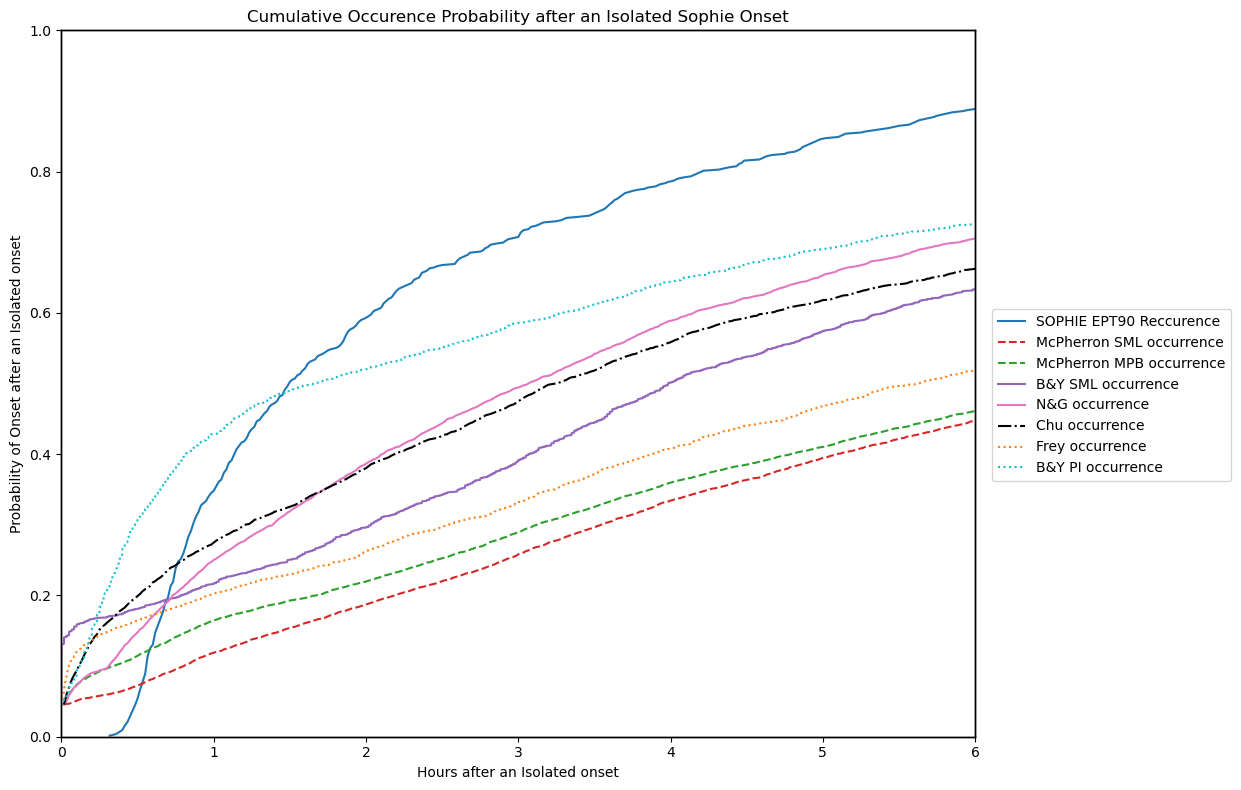

In [7]:
time_diff_recur, counts_recur = reccurence_func(sophienoflagonsetdf)
recurpdf = counts_recur/sum(counts_recur)
recurcdf = np.cumsum(recurpdf)

time_diff_ngsml, counts_ngsml = reccurence_func(newelldf)
ngsmlpdf = counts_ngsml/sum(counts_ngsml)
ngsmlcdf = np.cumsum(ngsmlpdf)

time_diff_bysml, counts_bysml = reccurence_func(bysmldf)
bysmlpdf = counts_bysml/sum(counts_bysml)
bysmlcdf = np.cumsum(bysmlpdf)

time_diff_chu, counts_chu = reccurence_func(chudf)
chupdf = counts_chu/sum(counts_chu)
chucdf = np.cumsum(chupdf)

time_diff_frey, counts_frey = reccurence_func(freydf)
freypdf = counts_frey/sum(counts_frey)
freycdf = np.cumsum(freypdf) 

time_diff_bypi, counts_bypi = reccurence_func(bypidf)
bypipdf = counts_bypi/sum(counts_bypi)
bypicdf = np.cumsum(bypipdf)

time_diff_mcpsml, counts_mcpsml = reccurence_func(mcpsmldf)
mcpsmlpdf = counts_mcpsml/sum(counts_mcpsml)
mcpsmlcdf = np.cumsum(mcpsmlpdf)

time_diff_mcpmpb, counts_mcpmpb = reccurence_func(mcpmpbdf)
mcpmpbpdf = counts_mcpmpb/sum(counts_mcpmpb)
mcpmpbcdf = np.cumsum(mcpmpbpdf)


fig, ax1  = plt.subplots(figsize=(10,8))
locator = ticker.MultipleLocator(base=1)
c = 'tab:blue'
ax1.plot(time_diff_recur,recurcdf,color=c,label='SOPHIE EPT90 Reccurence')
ax1.set_xlabel("Hours after an Isolated onset")
ax1.set_ylabel("Probability of Onset after an Isolated onset")
ax1.set_xlim(0,6)
ax1.set_ylim(0,1)

c = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(time_diff_mcpsml,mcpsmlcdf,color=c,label='McPherron SML occurrence', ls='--')
ax2.yaxis.set_visible(False)

c = 'tab:green'
ax3 = ax1.twinx()
ax3.plot(time_diff_mcpmpb,mcpmpbcdf,color=c,label='McPherron MPB occurrence', ls='--')
ax3.yaxis.set_visible(False)

c = 'tab:purple'
ax3 = ax1.twinx()
ax3.plot(time_diff_bysml,bysmlcdf,color=c,label='B&Y SML occurrence', ls='-')
ax3.yaxis.set_visible(False)

c = 'tab:pink'
ax4 = ax1.twinx()
ax4.plot(time_diff_ngsml, ngsmlcdf,color=c,label='N&G occurrence', ls='-')
ax4.yaxis.set_visible(False)

c = 'black'
ax5 = ax1.twinx()
ax5.plot(time_diff_chu,chucdf,color=c,label='Chu occurrence',ls='-.')
ax5.yaxis.set_visible(False)

c = 'tab:orange'
ax6 = ax1.twinx()
ax6.plot(time_diff_frey, freycdf,color=c,label='Frey occurrence',ls=':')
ax6.yaxis.set_visible(False)

c = 'tab:cyan'
ax7 = ax1.twinx()
ax7.plot(time_diff_bypi, bypicdf, color=c,label='B&Y PI occurrence', ls=':')
ax7.yaxis.set_visible(False)

ax1.xaxis.set_major_locator(locator)
ax1.set_title('Cumulative Occurence Probability after an Isolated Sophie Onset')
fig.tight_layout()
fig.legend(bbox_to_anchor=(.99, .5), loc='center left')
